# Time Series Forecasting - Multivariable Time Series Models for Stock Market Prediction

## import Packages

In [1]:
import math 
import numpy as np 
import pandas as pd 
from datetime import date, timedelta, datetime 
from pandas.plotting import register_matplotlib_converters 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import seaborn as sns 
import mysql.connector as mysql
import yfinance as yf


## Evaluasi Forecasting
### RMSE, MAE, MAPE

In [2]:
class EvaluasiForecasting:
    def rmse_metric(actual, predicted):
        mean_error = np.square(np.subtract(actual,predicted)).mean()
        return math.sqrt(mean_error)

    def mae_metric(actual, predicted):
        y_true, predicted = np.array(actual), np.array(predicted)
        return np.mean(np.abs(actual - predicted))

    def mape_metric(actual, predicted): 
        actual, predicted = np.array(actual), np.array(predicted)
        return np.mean(np.abs((actual - predicted) / actual)) * 100

In [3]:
class DataLoad:
    def read_data(start_date,end_date, symbol_dataset):
        df = []
        df = yf.download(symbol_dataset, start=start_date, end=end_date)
        
        return df

In [4]:
class Preprocessing:
    def feature_selection(df):
        # Indexing Batches
        train_df = df.sort_values(by=['Date']).copy()

        # Daftar Fitur yang digunakan
        FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume']
        data = pd.DataFrame(train_df)
        data_filtered = data[FEATURES]

        # menambahkan kolom prediksi dan menetapkan nilai dummy untuk menyiapkan data untuk penskalaan
        data_filtered_ext = data_filtered.copy()
        data_filtered_ext['Prediction'] = data_filtered_ext['Close']
        return data_filtered_ext, data_filtered, data
    
    def reshape_data(data_filtered):
        # Dapatkan jumlah baris dalam data
        nrows = data_filtered.shape[0]

        # Convert the data ke numpy values
        np_data_unscaled = np.array(data_filtered)
        np_data = np.reshape(np_data_unscaled, (nrows, -1))
        
        return np_data_unscaled, np_data

    def min_max(np_data_unscaled,data_filtered_ext):
        scaler = MinMaxScaler(feature_range=(0,1))
        np_data_scaled = scaler.fit_transform(np_data_unscaled)

        # Membuat scaler terpisah yang berfungsi pada satu kolom untuk prediksi penskalaan
        scaler_pred = MinMaxScaler(feature_range=(0,1))
        df_Close = pd.DataFrame(data_filtered_ext['Close'])
        np_Close_scaled = scaler_pred.fit_transform(df_Close)
        
        return np_data_scaled, np_Close_scaled, scaler_pred
    
    def inverse_minmax(y_pred_scaled, y_test):
        y_pred = scaler_pred.inverse_transform(y_pred_scaled)
        y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
        
        return y_pred, y_test_unscaled
    
    def partition_dataset(sequence_length, data, index_Close):
        x, y = [], []
        data_len = data.shape[0]
        for i in range(sequence_length, data_len):
            x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
            y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction

        # Convert the x and y to numpy arrays
        x = np.array(x)
        y = np.array(y)
        return x, y
    
    def splitting_dataset(np_data_scaled,data):
        # Set the sequence length - this is the timeframe used to make a single prediction
        sequence_length = 1

        # Prediction Index
        index_Close = data.columns.get_loc("Close")

        # Split the training data into train and train data sets
        # As a first step, we get the number of rows to train the model on 80% of the data 
        train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

        # Create the training and test data
        train_data = np_data_scaled[0:train_data_len, :]
        test_data = np_data_scaled[train_data_len - sequence_length:, :]
        
        # Generate training data and test data
        x_train, y_train = Preprocessing.partition_dataset(sequence_length, train_data, index_Close)
        x_test, y_test = Preprocessing.partition_dataset(sequence_length, test_data, index_Close)
        
        return x_train, y_train, x_test, y_test, train_data_len

In [19]:
class LSTM_unit:
    def training_model(x_train, y_train, x_test, y_test, unit, epoch):
        # Configure the neural network model
        model = Sequential()
        model.add(Bidirectional(LSTM(unit, return_sequences=False, 
                                     input_shape=(x_train.shape[1], 
                                                  x_train.shape[2]))))
        model.add(Dense(1))

        # Compile the model
        model.compile(optimizer='adam', loss='mse')
        # Training the model
        early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
        history = model.fit(x_train, y_train, 
                batch_size=16, 
                epochs=epoch,
                validation_data=(x_test, y_test)
               )
        return x_test, model, history
        
    def predict_model(x_test,model):
        y_pred_scaled = model.predict(x_test)
        return y_pred_scaled

## Change the indicators

In [20]:
#hyperparameters
# epochs  = [10,100,1000]
# units = [10,50,128]
epoch = 10
unit = 10

## Load the Time Series Data use Yahoo finance

In [21]:

start_date = '2017-01-01'

end_date = '2017-03-30'
symbol_dataset = 'PSDN.jk'
df = DataLoad.read_data(start_date, end_date,symbol_dataset)


if df.shape[0]>=1250:
    term_status = "long"
elif df.shape[0]>=250:
    term_status = "mid"
else:
    term_status = "short"
                


# # Create a quick overview of the dataset
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-02,134.0,134.0,134.0,134.0,134.0,0
2017-01-03,135.0,139.0,135.0,139.0,139.0,4500
2017-01-04,139.0,139.0,136.0,136.0,136.0,40500
2017-01-05,135.0,141.0,135.0,141.0,141.0,6900
2017-01-06,136.0,140.0,136.0,140.0,140.0,200
...,...,...,...,...,...,...
2017-03-22,160.0,161.0,160.0,161.0,161.0,4400
2017-03-23,170.0,170.0,162.0,162.0,162.0,10800
2017-03-24,170.0,181.0,144.0,146.0,146.0,13006800


## Feature Selection and Scaling

In [22]:
data_filtered_ext, data_filtered, data = Preprocessing.feature_selection(df)

In [23]:
np_data_unscaled, np_data = Preprocessing.reshape_data(data_filtered)

In [24]:
np_data_scaled, np_Close_scaled, scaler_pred = Preprocessing.min_max(np_data_unscaled,data_filtered_ext)

## Split Train and Test

In [25]:
x_train, y_train, x_test, y_test, train_data_len = Preprocessing.splitting_dataset(np_data_scaled,data) 

## Train the Multivariable Prediciton Model

In [27]:
x_test,model,history=LSTM_unit.training_model(x_train, y_train, x_test, y_test, unit, epoch) 

Epoch 1/10
4/4 [==============================] - 4s 202ms/step - loss: 0.1721 - val_loss: 0.1540
Epoch 2/10
4/4 [==============================] - 0s 9ms/step - loss: 0.1537 - val_loss: 0.1354
Epoch 3/10
4/4 [==============================] - 0s 8ms/step - loss: 0.1371 - val_loss: 0.1189
Epoch 4/10
4/4 [==============================] - 0s 8ms/step - loss: 0.1224 - val_loss: 0.1033
Epoch 5/10
4/4 [==============================] - 0s 8ms/step - loss: 0.1083 - val_loss: 0.0893
Epoch 6/10
4/4 [==============================] - 0s 8ms/step - loss: 0.0959 - val_loss: 0.0763
Epoch 7/10
4/4 [==============================] - 0s 8ms/step - loss: 0.0840 - val_loss: 0.0650
Epoch 8/10
4/4 [==============================] - 0s 8ms/step - loss: 0.0734 - val_loss: 0.0546
Epoch 9/10
4/4 [==============================] - 0s 8ms/step - loss: 0.0639 - val_loss: 0.0458
Epoch 10/10
4/4 [==============================] - 0s 8ms/step - loss: 0.0551 - val_loss: 0.0380


In [28]:
model

In [29]:
y_test

array([0.68627451, 0.50980392, 0.52941176, 0.52941176, 0.50980392,
       0.50980392, 0.50980392, 0.52941176, 0.54901961, 0.23529412,
       0.23529412, 0.23529412])

In [30]:
y_pred_scaled = LSTM_unit.predict_model(x_test,model)

1/1 [==============================] - 1s 539ms/step


In [31]:
y_pred, y_test_unscaled = Preprocessing.inverse_minmax(y_pred_scaled, y_test)


In [32]:
print(f'Jumlah data y_train: {y_train.shape[0]}')
print(f'Jumlah data y_pred: {y_pred.shape[0]}')
print(f'Jumlah data y_test_unscaled: {y_test_unscaled.shape[0]}')

Jumlah data y_train: 49
Jumlah data y_pred: 12
Jumlah data y_test_unscaled: 12


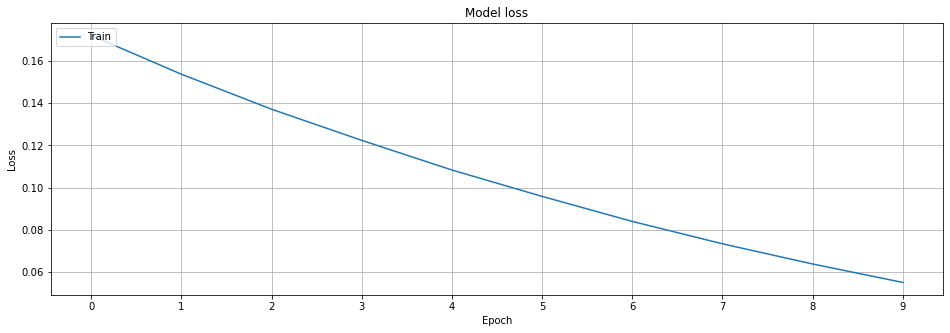

In [33]:
# # Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epoch))
plt.legend(["Train"], loc="upper left")
plt.grid()
plt.show()

## Evaluate Model performance

In [16]:
# Root Mean Square Error (RMSE)
RMSE = EvaluasiForecasting.rmse_metric(y_test_unscaled, y_pred)
RMSE = np.round(RMSE, 2)
print(f'Root Mean Square Error (RMSE): {RMSE}')

# Mean Absolute Error (MAE)
MAE = EvaluasiForecasting.mae_metric(y_test_unscaled, y_pred)
MAE = np.round(MAE, 2)
print(f'Median Absolute Error (MAE): {MAE}')

# Mean Absolute Percentage Error (MAPE)
MAPE = EvaluasiForecasting.mape_metric(y_test_unscaled, y_pred)
MAPE = np.round(MAPE, 2)
print(f'Mean Absolute Percentage Error (MAPE): {MAPE} %')

Root Mean Square Error (RMSE): 18.25
Median Absolute Error (MAE): 16.84
Mean Absolute Percentage Error (MAPE): 10.49 %


## Visualize the Data

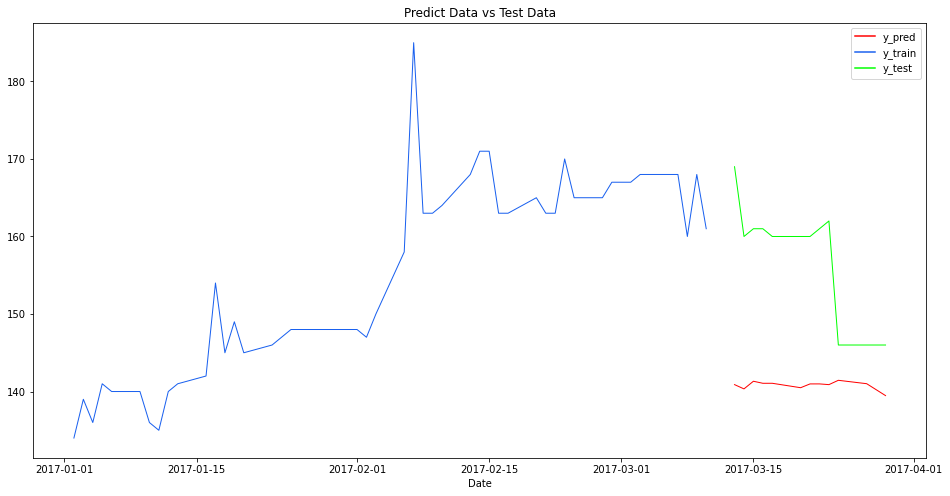

In [17]:
# The date from which on the date is displayed
display_start_date = start_date


# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
# valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Predict Data vs Test Data")

sns.set_palette(["#FF0000", "#1960EF", "#00FF00"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
# df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
# ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
# plt.savefig("../results/LSTM/plots/" + symbol_dataset +'_LSTM-'+ 
#                             term_status + '_e='+ str(epoch) +'_u='+ str(unit) + '.pdf')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

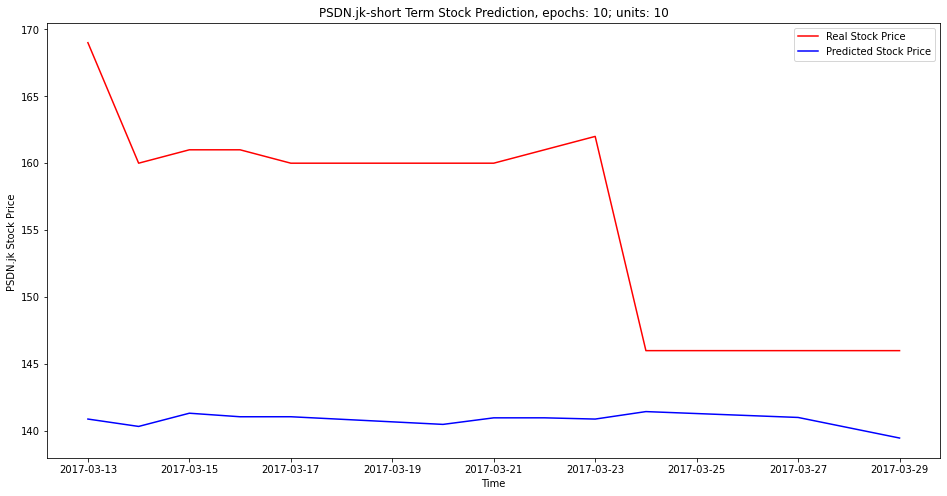

In [18]:
plt.figure()
plt.subplots(figsize=(16, 8))
plt.plot(df_union_zoom['y_test'], color = 'red', label = 'Real Stock Price')
plt.plot(df_union_zoom['y_pred'], color = 'blue', label = 'Predicted Stock Price')
plt.title(symbol_dataset +"-"+ term_status +' Term Stock Prediction, epochs: '+ str(epoch) +'; units: '+str(unit))
plt.xlabel('Time')
plt.ylabel(symbol_dataset +' Stock Price ')
plt.legend()

## Save a new Dataset

In [19]:
# new_data = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'real_close'})
# new_data['close_lstm'] = y_pred

In [20]:
# #save to dataset
# df_new_data = pd.DataFrame(new_data)

In [21]:
# df_new_data.tail()

In [22]:
# df_new_data.to_csv("../results/LSTM/datasets/" + index_dataset
#                 +'_LSTM-'+ term_status + '_e='+ str(epoch) +'_u='+ str(unit) + '.csv', index=True)

In [23]:
# read_new_data = pd.read_csv("../results/LSTM/datasets/"+ term_status + symbol_dataset
#                    +'_LSTM-'+ term_status + '_e='+ str(epochs) +'_u='+ str(unit) + '.csv')
# read_new_data

## insert to Database

In [24]:
# #connect database
# mydb = mysql.connect(
#     host="localhost",
#     user="root",
#     password="",
#     database="db_tugasakhir"
# )
# mycursor = mydb.cursor()

# #insert to database
# sql = "INSERT INTO pengujian_lstm (datasets, start_dates, end_dates,epochs, units, RMSE, MAE, MAPE) VALUES (%s,%s,%s,%s,%s,%s,%s,%s)"
# val = (symbol_dataset, start_date, end_date, epochs, unit, RMSE, MAE, MAPE)

# mycursor.execute(sql,val)
# mydb.commit()